# Машинное обучение, МГУ ВМК

## Практическое задание 5

### Общая информация
Дата выдачи: 16.12.2018

Мягкий дедлайн: 23:59MSK 23.12.2018

Жесткий дедлайн: 23:59MSK 31.12.2018

**Выполнил: Попов Дмитрий**, группа 317

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-Username.ipynb
* Модуль hw5code.py
* Ссылка на посылку в Яндекс.Контесте: https://contest.yandex.ru/contest/9963/run-report/18271939/

В контест https://contest.yandex.ru/contest/9963/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__ 10 (все обязательные пункты) + 1 (бонус) - 1 (просрочка) = 10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import random, sys
my_seed = random.randrange(sys.maxsize) % 2**32
my_seed

2610548036

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

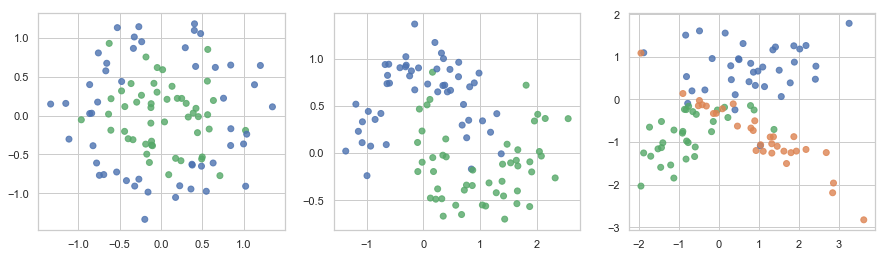

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

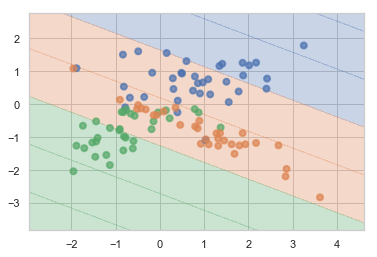

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [8]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

splits = [train_test_split(X, y, random_state=my_seed) for X, y in datasets]
trees  = [DecisionTreeClassifier().fit(X_train, y_train) for X_train, _, y_train, _ in splits]

train_scores = [accuracy_score(y_train, tree.predict(X_train)) for tree, (X_train, _, y_train, _) in zip(trees, splits)]
test_scores  = [accuracy_score(y_test, tree.predict(X_test)) for tree, (_, X_test, _, y_test) in zip(trees, splits)]

In [9]:
print(train_scores)
print(test_scores)

[1.0, 1.0, 1.0]
[0.84, 0.92, 0.84]


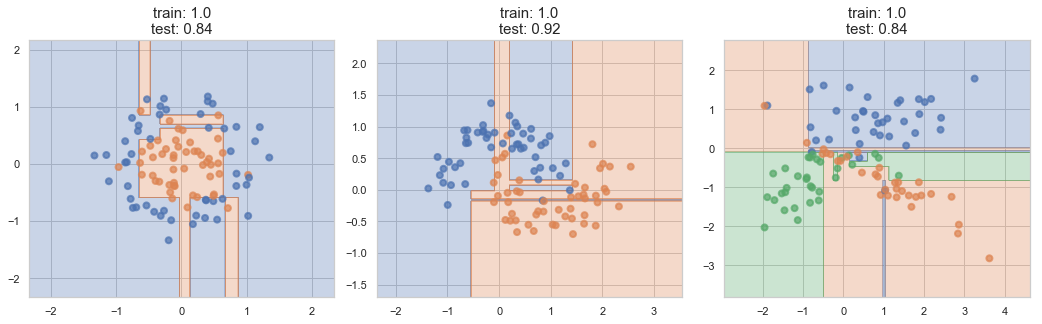

In [10]:
plt.figure(figsize=(15, 5))
for i, (tree, (X, y), test_score, train_score) in enumerate(zip(trees, datasets, test_scores, train_scores)):
    plt.subplot(1, 3, i + 1)
    plt.title(f'train: {train_score}\ntest: {test_score}', fontsize=15)
    plot_surface(tree, X, y)

In [11]:
depths = [3, 4, 2]
leaves = [5, 6, 3]

good_trees = [DecisionTreeClassifier(max_depth=d, max_leaf_nodes=l).fit(X_train, y_train)
              for d, l, (X_train, _, y_train, _) in zip(depths, leaves, splits)]

gtrain_scores = [accuracy_score(y_train, tree.predict(X_train)) 
                 for tree, (X_train, _, y_train, _) in zip(good_trees, splits)]
gtest_scores  = [accuracy_score(y_test, tree.predict(X_test)) 
                 for tree, (_, X_test, _, y_test) in zip(good_trees, splits)]

print(gtrain_scores)
print(gtest_scores)

[0.9333333333333333, 0.9733333333333334, 0.8533333333333334]
[0.88, 0.92, 0.88]


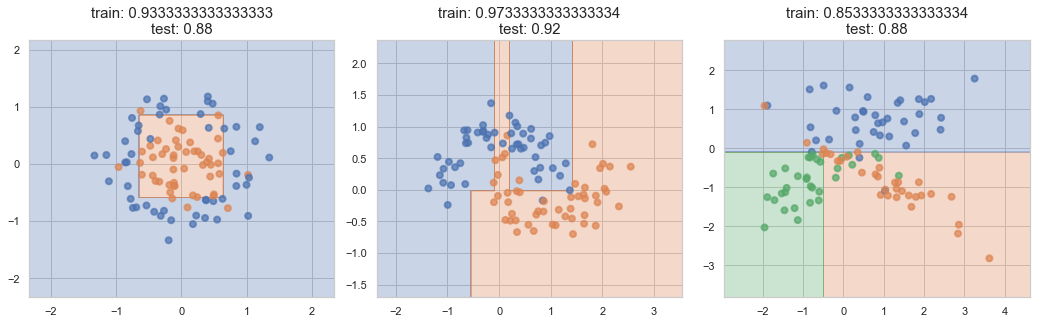

In [12]:
plt.figure(figsize=(15, 5))
for i, (tree, (X, y), test_score, train_score) in enumerate(zip(good_trees, datasets, gtest_scores, gtrain_scores)):
    plt.subplot(1, 3, i + 1)
    plt.title(f'train: {train_score}\ntest: {test_score}', fontsize=15)
    plot_surface(tree, X, y)

__Ответ:__ деревья для первого и третьего датасета переобучились сильно, для второго ситуация чуть лучше, хотя я всё равно вижу лишние деления. Для всех задач нужна меньшая глубина и меньшее количество листьев. Я подобрал получше.

__2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [13]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [14]:
def max_depth_scores(dataset_i, n):
    X_train, X_test, y_train, y_test = splits[dataset_i]
    depths = range(1, n)

    trees = [DecisionTreeClassifier(max_depth=d).fit(X_train, y_train) for d in depths]
    train_scores = [accuracy_score(y_train, tree.predict(X_train)) for tree in trees]
    test_scores  = [accuracy_score(y_test, tree.predict(X_test)) for tree in trees]
    
    return trees, train_scores, test_scores

In [15]:
def min_samples_leaf_scores(dataset_i, n):
    X_train, X_test, y_train, y_test = splits[dataset_i]
    samples = range(1, n)

    trees = [DecisionTreeClassifier(min_samples_leaf=s).fit(X_train, y_train) for s in samples]
    train_scores = [accuracy_score(y_train, tree.predict(X_train)) for tree in trees]
    test_scores  = [accuracy_score(y_test, tree.predict(X_test)) for tree in trees]
    
    return trees, train_scores, test_scores

In [16]:
def plot_scores(dataset_i, n, train_scores, test_scores, feature_name):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, n), train_scores[dataset_i][:n-1], label='train', color='g')
    plt.plot(range(1, n), test_scores[dataset_i][:n-1], label='test', color='r')
    plt.title('Train / Test accuracy ~ ' + feature_name, fontsize=15)
    plt.xlabel(feature_name)
    plt.ylabel('accuracy')
    plt.xticks(range(1, n))
    plt.legend()

In [17]:
def plot_surfaces(dataset_i, n, params, trees, train_scores, test_scores, feature_name):
    plt.figure(figsize=(16, 16))
    for i, (tree, feature) in enumerate(zip(trees[dataset_i][:n], params[:n])):
        plt.subplot(3, n // 3, i + 1)
        plot_surface(tree, *datasets[dataset_i])
        plt.title(feature_name + '={}\ntrain: {:.2f}\ntest: {:.2f}'.format(feature,
                                                                           train_scores[dataset_i][i],
                                                                           test_scores[dataset_i][i]), fontsize=15)

In [18]:
depths_res = [i for i in zip(*[max_depth_scores(i, 16) for i in range(3)])]

In [19]:
min_samples_res = [i for i in zip(*[min_samples_leaf_scores(i, 16) for i in range(3)])]

## Dataset 1

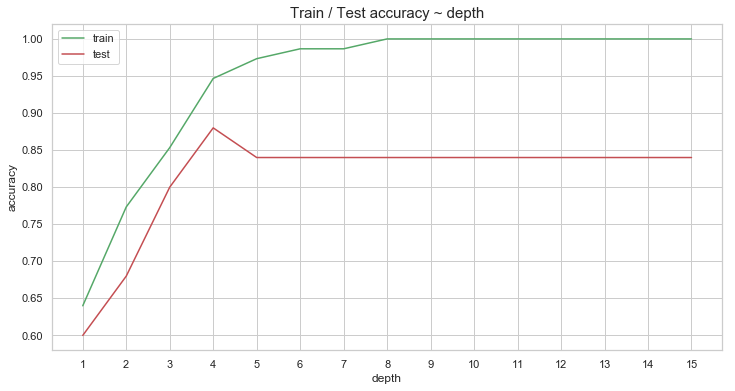

In [20]:
plot_scores(0, 16, depths_res[1], depths_res[2], 'depth')

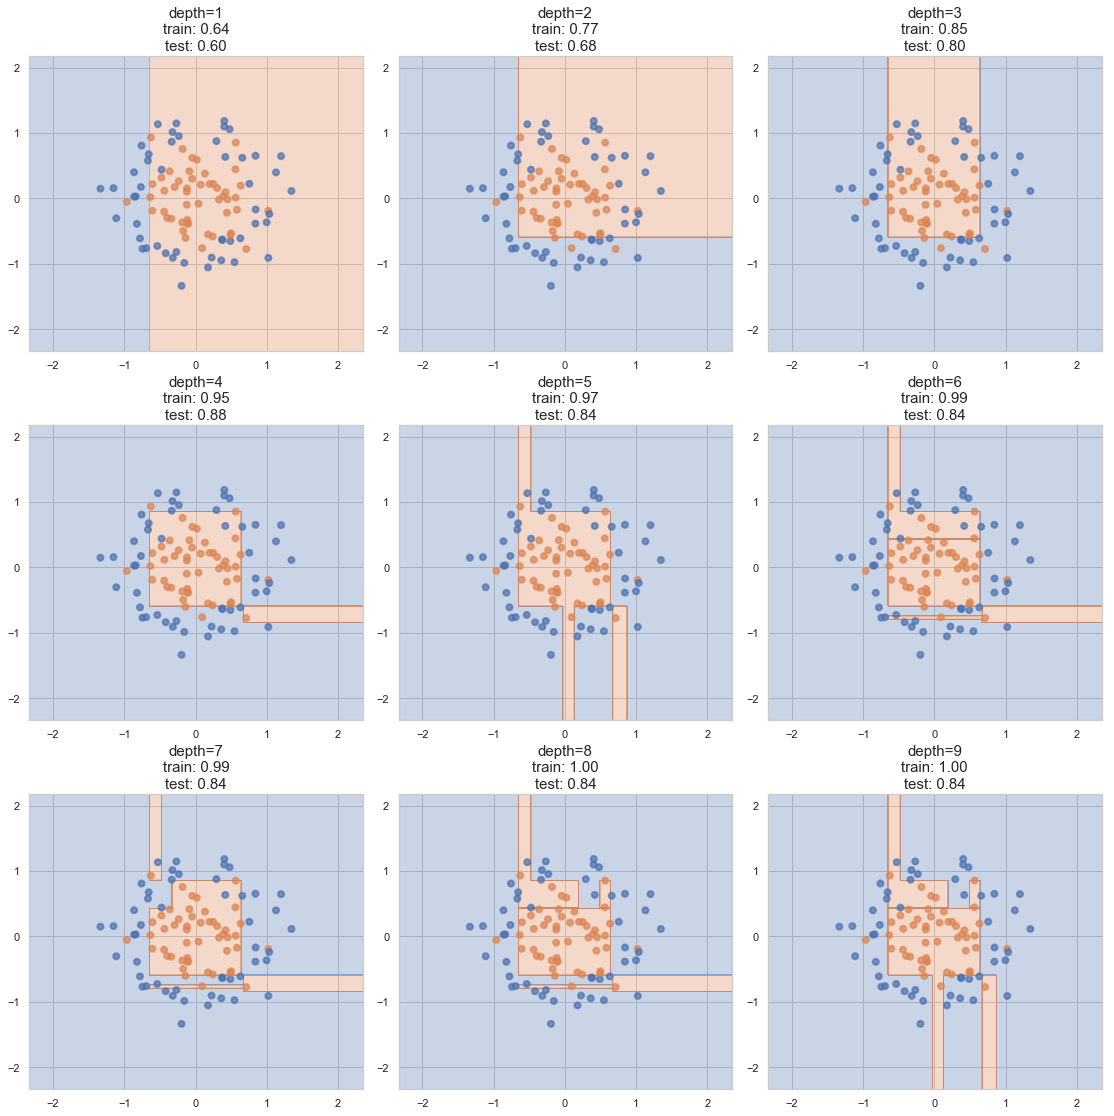

In [21]:
plot_surfaces(0, 9, range(1, 10), depths_res[0], depths_res[1], depths_res[2], 'depth')

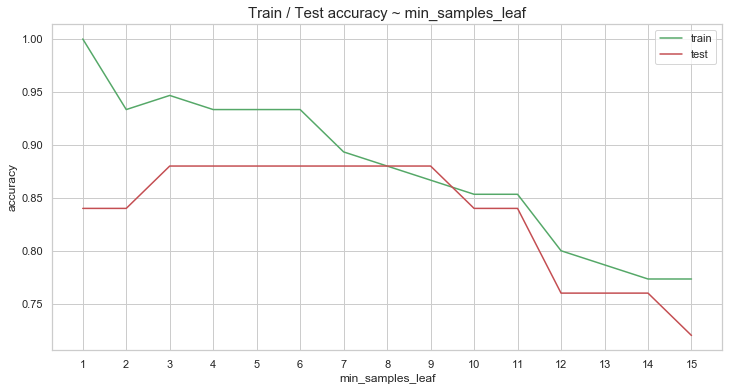

In [22]:
plot_scores(0, 16, min_samples_res[1], min_samples_res[2], 'min_samples_leaf')

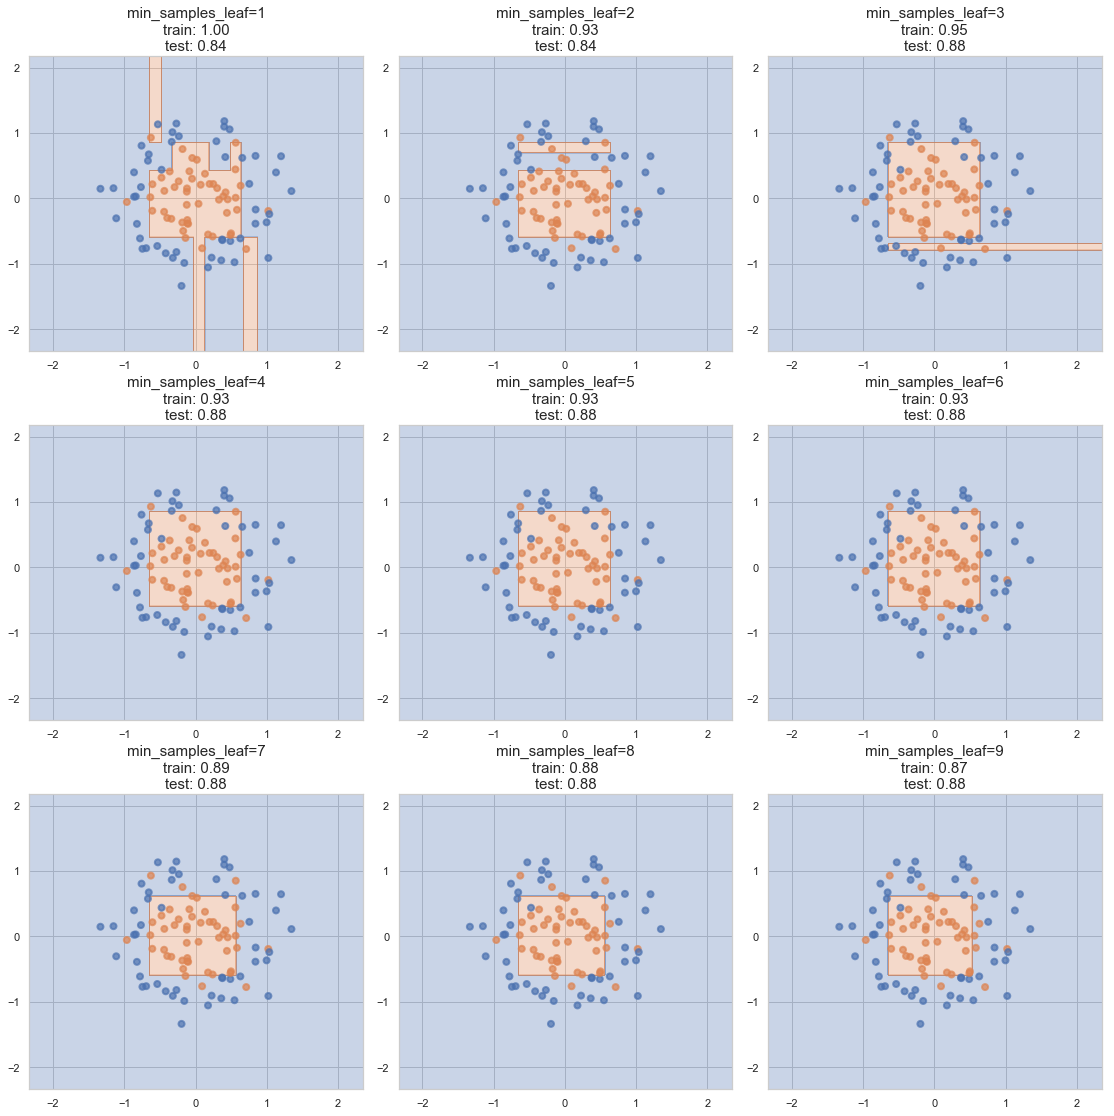

In [23]:
plot_surfaces(0, 9, range(1, 10), min_samples_res[0], min_samples_res[1], min_samples_res[2], 'min_samples_leaf')

## Dataset 2

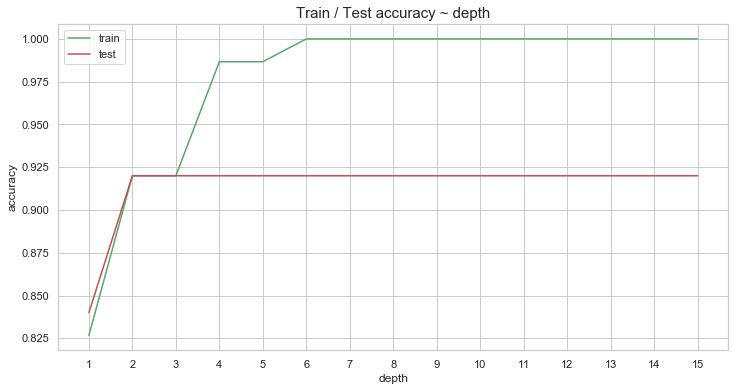

In [24]:
plot_scores(1, 16, depths_res[1], depths_res[2], 'depth')

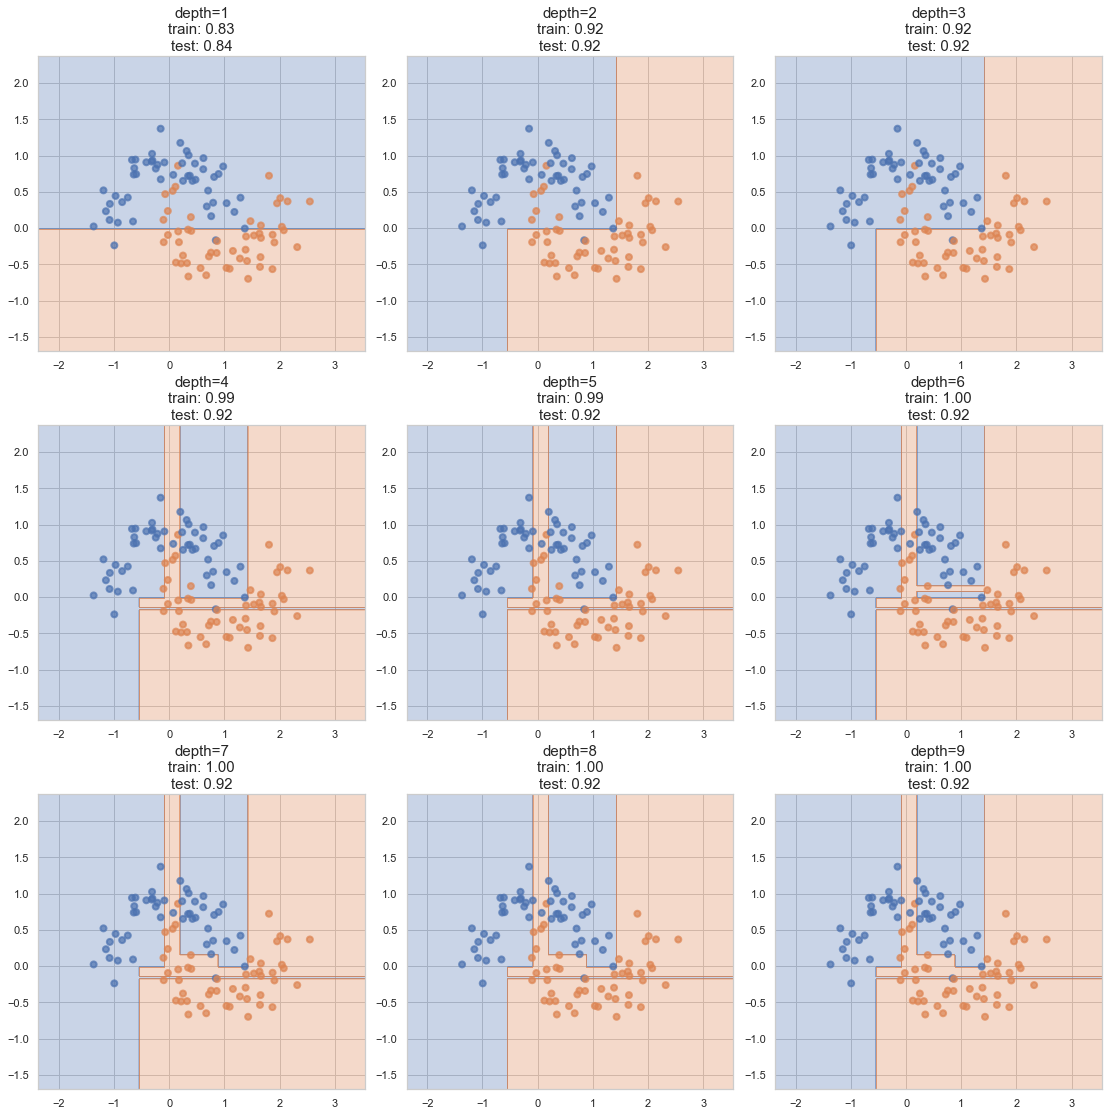

In [25]:
plot_surfaces(1, 9, range(1, 10), depths_res[0], depths_res[1], depths_res[2], 'depth')

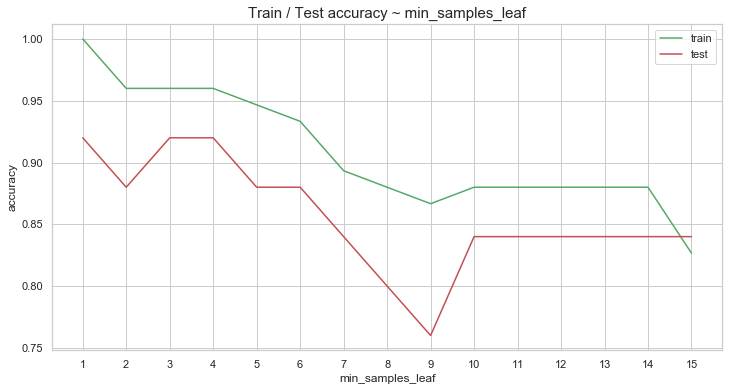

In [26]:
plot_scores(1, 16, min_samples_res[1], min_samples_res[2], 'min_samples_leaf')

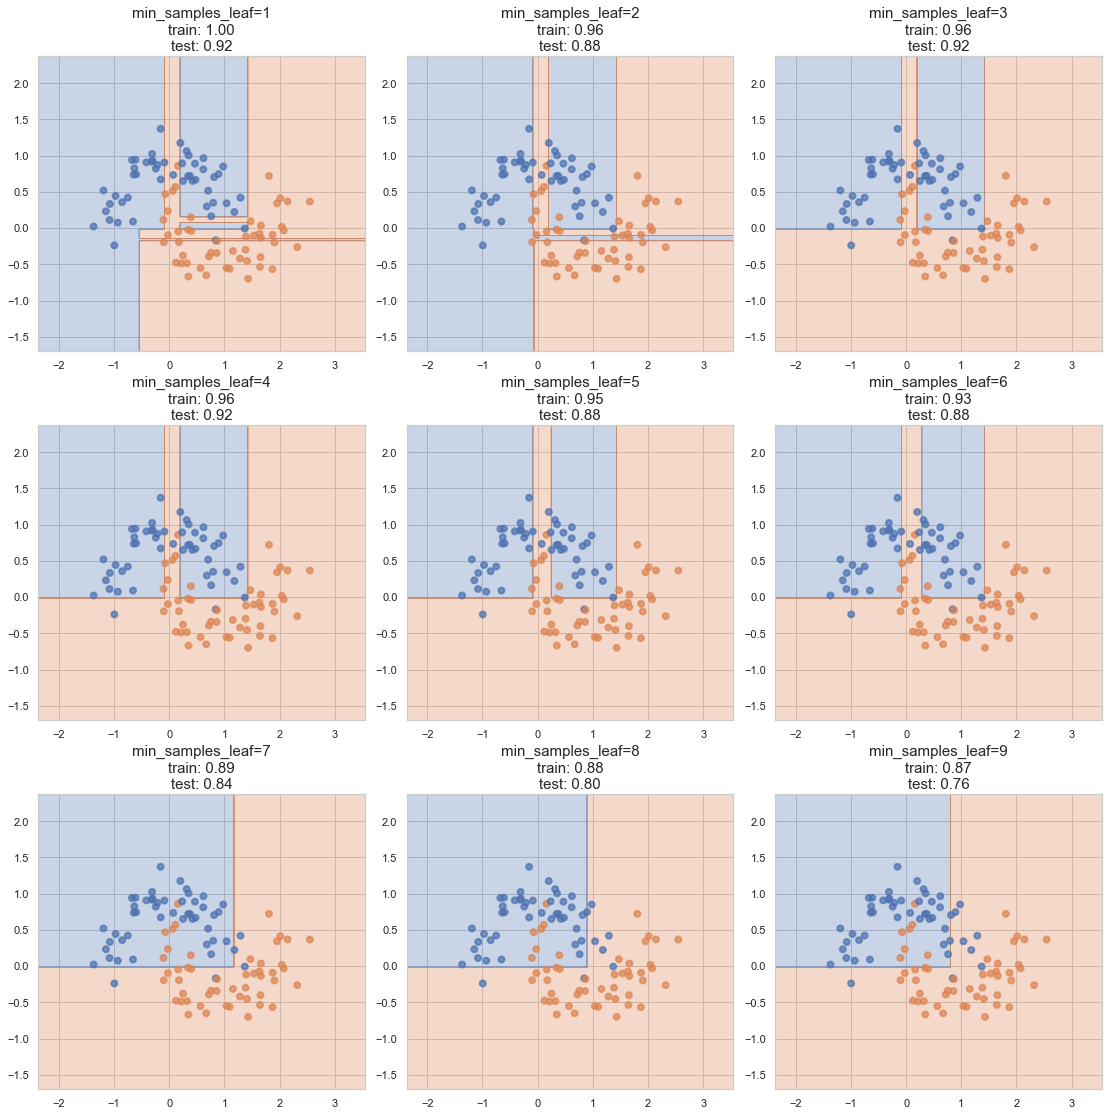

In [27]:
plot_surfaces(1, 9, range(1, 10), min_samples_res[0], min_samples_res[1], min_samples_res[2], 'min_samples_leaf')

## Dataset 3

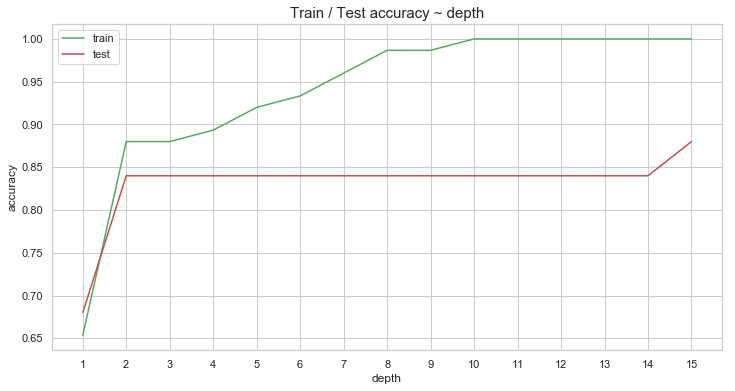

In [28]:
plot_scores(2, 16, depths_res[1], depths_res[2], 'depth')

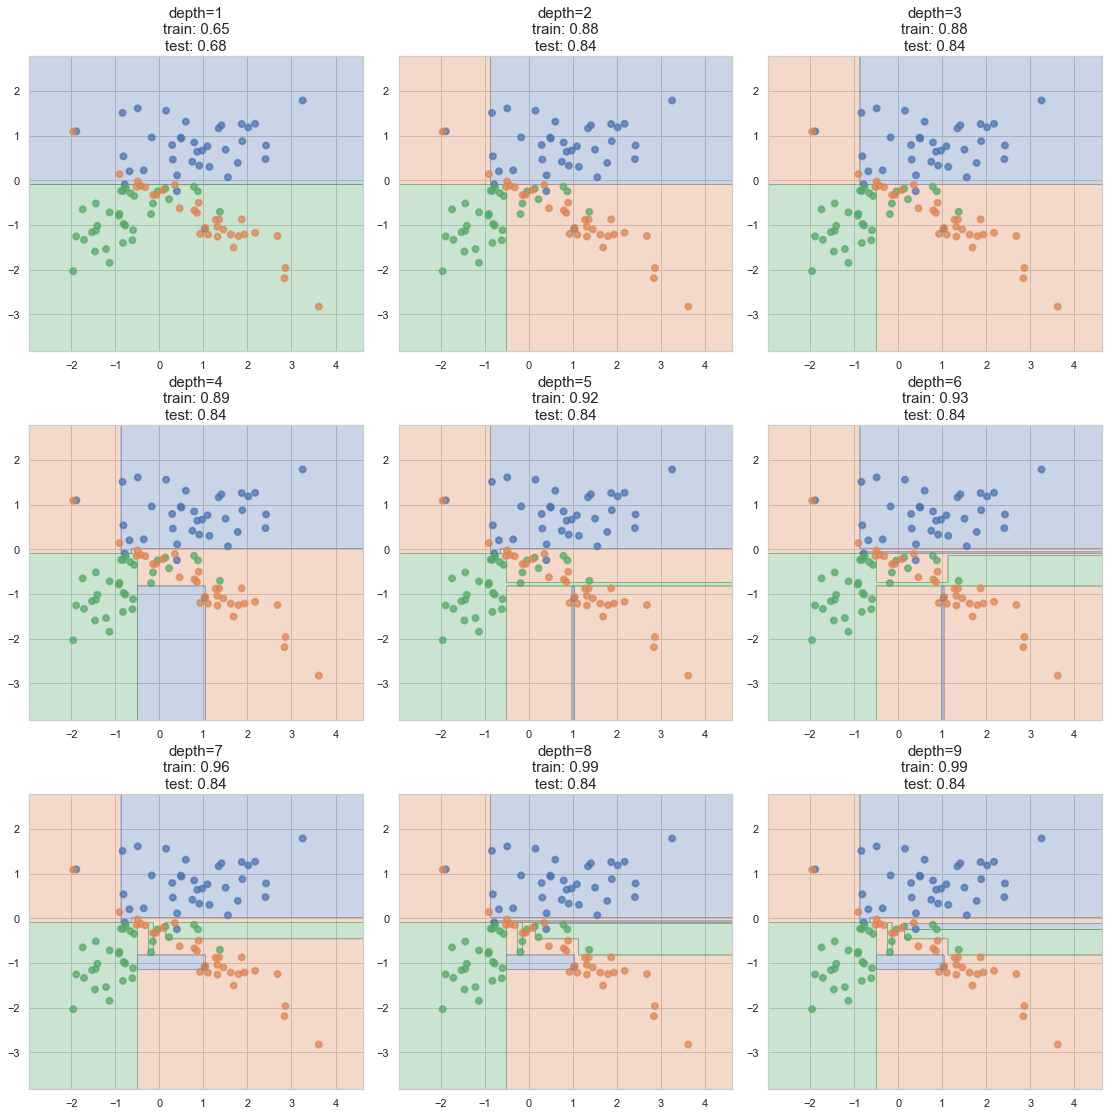

In [29]:
plot_surfaces(2, 9, range(1, 10), depths_res[0], depths_res[1], depths_res[2], 'depth')

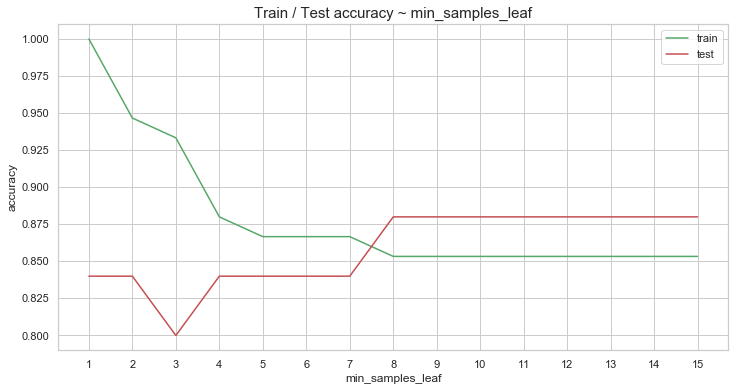

In [30]:
plot_scores(2, 16, min_samples_res[1], min_samples_res[2], 'min_samples_leaf')

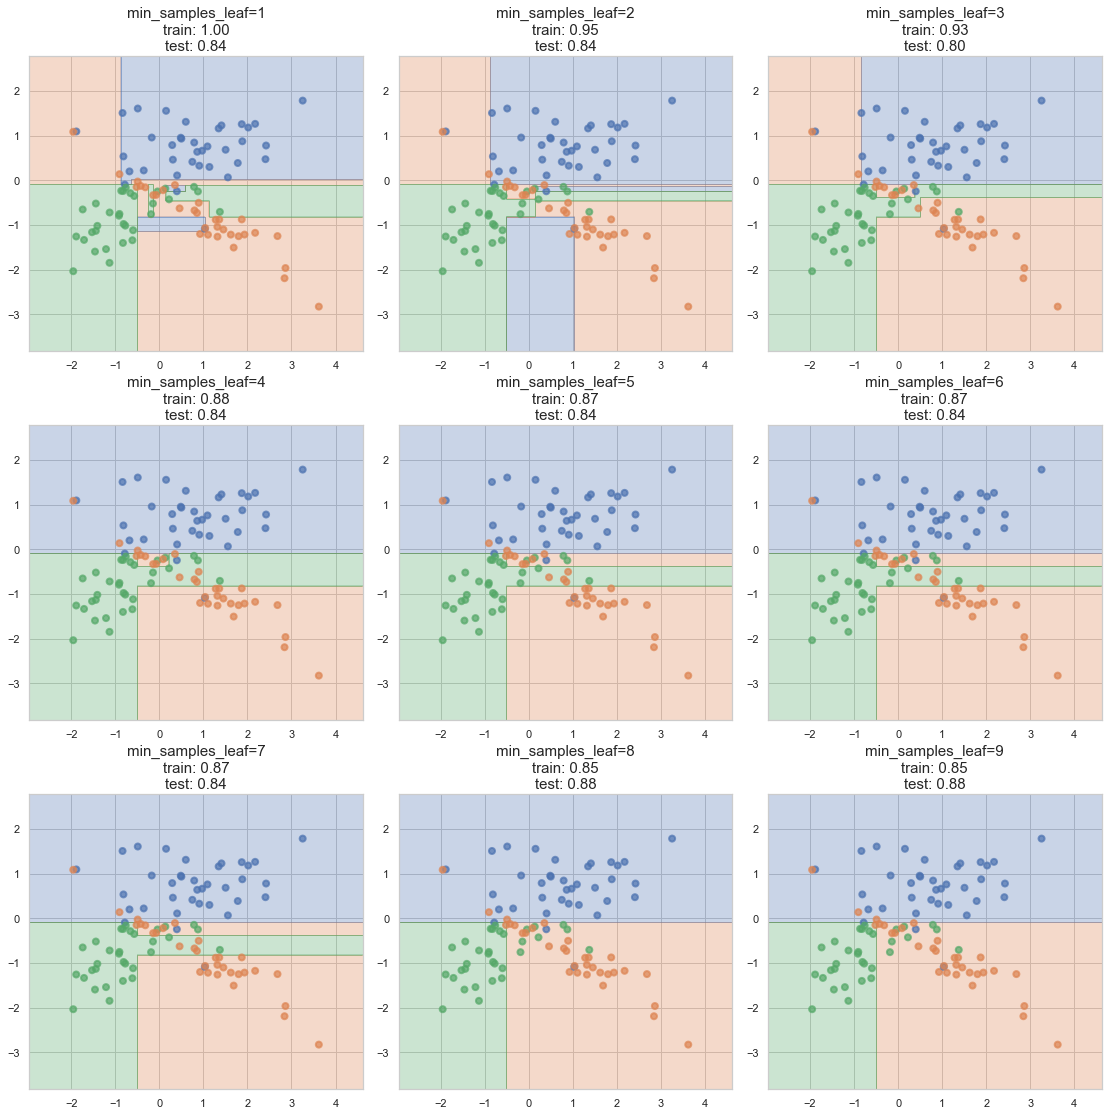

In [31]:
plot_surfaces(2, 9, range(1, 10), min_samples_res[0], min_samples_res[1], min_samples_res[2], 'min_samples_leaf')

__Ответ:__ эхх, надо читать все задания, прежде чем браться выполнять первое...

Ну, давайте разберём по частям. Универсальное ожидание - что обобщающая способность в зависимости от сложности модели сначала увеличивается, потом уменьшается. Регуляризация сложность модели уменьшает. В данном случае глубина дерева увеличивает сложность, min_samples_leaf уменьшает. 

Зависимость от глубины удовлетворяет ожиданиям, кроме второго датасета - в нём модель перестаёт изменяться после определённого порога, при этом обобщающая способность растёт вплоть до него. 

Зависимость от регуляризации тоже удовлетворяет ожиданиям, тоже кроме второго датасета - там она помогает, и только начинает мешать со временем.

**UPD:** после того, как я перезапустил ноутбук, сид поменялся и все графики стали другими...
Но теперь хотя бы общая тенденция распространяется на почти все примеры.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$

$H(R) = 1-p_1^2-p_0^2$

In [32]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator


def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    sorted_args = np.argsort(feature_vector)
    sorted_feature = feature_vector[sorted_args]
    thresholds = (sorted_feature[:-1] + sorted_feature[1:]) / 2
    classes = target_vector[sorted_args]

    R = classes.size

    R_l = np.arange(1, R)
    R_1l = classes.cumsum()

    p_1l = R_1l[:-1] / R_l
    p_0l = 1 - p_1l

    p_1r = (R_1l[-1] - R_1l[:-1]) / (R - R_l)
    p_0r = 1 - p_1r

    ginis = R_l/R*(p_1l**2 + p_0l**2 - 1) + (1 - R_l/R)*(p_1r**2 + p_0r**2 - 1)
    hole_mask = sorted_feature[1:] > sorted_feature[:-1]

    ginis = ginis[hole_mask]
    thresholds = thresholds[hole_mask]

    best_idx = np.argmax(ginis)
    threshold_best = thresholds[best_idx]
    gini_best = ginis[best_idx]

    return thresholds, ginis, threshold_best, gini_best


class DecisionTree(BaseEstimator):
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self.feature_types = feature_types
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.depth = 0

        self._TERMINAL = 0
        self._NONTERMINAL = 1
        self._REAL = 2
        self._CATEGORICAL = 3
        self._LEFT_CHILD = 4
        self._RIGHT_CHILD = 5
        self._TYPE = 6
        self._CLASS = 7
        self._THRESHOLD = 8
        self._FEATURE_SPLIT = 9

    def _fit_node(self, sub_X, sub_y, node, depth):
        self.depth = max(self.depth, depth)
        if np.all(sub_y == sub_y[0]):
            node[self._TYPE] = self._TERMINAL
            node[self._CLASS] = sub_y[0]
            return

        if (self.min_samples_leaf is not None and sub_X.shape[0] < self.min_samples_leaf) or\
           (self.max_depth is not None and depth >= self.max_depth):
            node[self._TYPE] = self._TERMINAL
            node[self._CLASS] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self.feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}

                for key, current_count in counts.items():
                    current_click = clicks.get(key, 0)
                    ratio[key] = current_click / current_count

                sorted_categories = sorted(ratio.keys(), key=lambda cat: ratio[cat])
                categories_map = dict(zip(sorted_categories, range(len(sorted_categories))))

                feature_vector = np.array([categories_map[x] for x in sub_X[:, feature]])
            else:
                raise ValueError

            if (feature_vector == feature_vector[0]).all():
                continue

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                feature_split = feature_vector < threshold
                if min(feature_split.sum(), (1 - feature_split).sum()) == 0:
                    continue

                if self.min_samples_split is not None and \
                   min(feature_split.sum(), (1 - feature_split).sum()) < self.min_samples_split:
                    continue

                split = feature_split
                feature_best = feature
                gini_best = gini

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = {cat for cat, enc_cat in categories_map.items() if enc_cat < threshold}
                else:
                    raise ValueError

        if feature_best is None:
            node[self._TYPE] = self._TERMINAL
            node[self._CLASS] = Counter(sub_y).most_common(1)[0][0]
            return

        node[self._TYPE] = self._NONTERMINAL

        node[self._FEATURE_SPLIT] = feature_best
        if self.feature_types[feature_best] == "real":
            node[self._THRESHOLD] = threshold_best
        elif self.feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node[self._LEFT_CHILD], node[self._RIGHT_CHILD] = {}, {}

        self._fit_node(sub_X[split], sub_y[split], node[self._LEFT_CHILD], depth + 1)
        self._fit_node(sub_X[~split], sub_y[~split], node[self._RIGHT_CHILD], depth + 1)

    def _predict_node(self, x, node):
        if node[self._TYPE] == self._TERMINAL:
            return node[self._CLASS]
        elif node[self._TYPE] == self._NONTERMINAL:
            feature_type = self.feature_types[node[self._FEATURE_SPLIT]]
            if feature_type == "real":
                if x[node[self._FEATURE_SPLIT]] < node[self._THRESHOLD]:
                    return self._predict_node(x, node[self._LEFT_CHILD])
                else:
                    return self._predict_node(x, node[self._RIGHT_CHILD])
            elif feature_type == "categorical":
                if x[node[self._FEATURE_SPLIT]] in node["categories_split"]:
                    return self._predict_node(x, node[self._LEFT_CHILD])
                else:
                    return self._predict_node(x, node[self._RIGHT_CHILD])
            else:
                raise ValueError
        else:
            raise ValueError

    def fit(self, X, y):
        self._depth = self._fit_node(X, y, self._tree, 0)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


__4. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [33]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd
students = pd.read_csv('data/students.csv')

In [34]:
students.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [35]:
X = students.drop(columns=' UNS')
y = students[' UNS']

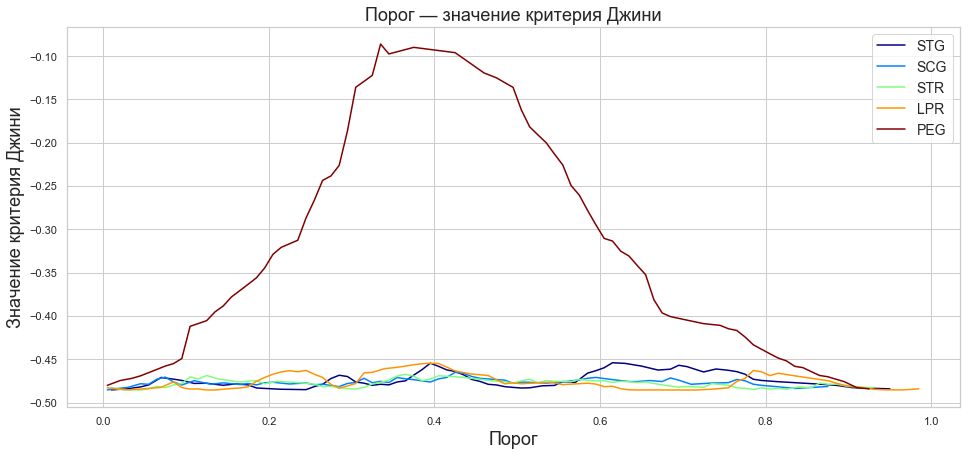

In [36]:
plt.figure(figsize=(16, 7))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 5))))
plt.title('Порог — значение критерия Джини', fontsize=18)
for i, col in enumerate(X.columns):
    th, gi, th_best, gi_best = find_best_split(X.values[:, i], y.values)
    plt.plot(th, gi, label=col)
    plt.xlabel('Порог', fontsize=18)
    plt.ylabel('Значение критерия Джини', fontsize=18)
plt.legend(loc='upper right', prop={'size': 14})
plt.grid(True)
plt.show()

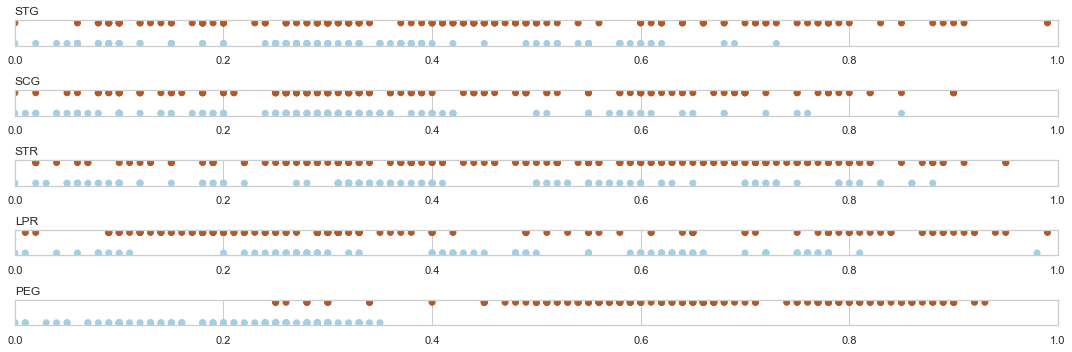

In [37]:
fig = plt.figure(figsize=(15, 5))
for i, col in enumerate(X.columns):
    plt.subplot(len(X.columns), 1, i + 1)
    plt.scatter(X.iloc[:, i], y, c=y, cmap='Paired')
    plt.yticks([])
    plt.xlim(0, 1)
    plt.title(col, loc='left', fontsize=12)
plt.tight_layout()

__5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** деление следует произвести по признаку PEG. Результат согласуется с оценкой scatter-графиков. 

Поскольку хорошее деление выборки должно относить много объектов одного класса влево и много другого класса - вправо, сдвиг порога должен приводить к ухудшению выигрыша - так как мы начинаем относить первый класс вправо и наоборот. Это значит, что из идеальности признака следует наличие пика на графике, в обе стороны от которого значение индекса Джини убывает. На шумовых признаках же следует ожидать колебание вокруг одного значения - от движения порога на любое расстояние между поддеревьями должно перелетать примерно одинаково объектов разных классов.

__6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [38]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
mushrooms = pd.read_csv('data/agaricus-lepiota.csv', header=None)

In [39]:
mushrooms.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [40]:
from sklearn.preprocessing import LabelEncoder

def enc_labels(data):
    df_new = pd.DataFrame()
    for col in data.columns:
        df_new[col] = LabelEncoder().fit_transform(data[col])
    return df_new

In [41]:
mushrooms_enc = enc_labels(mushrooms)

In [42]:
train_scores = []
test_scores = []
tree_depths = []

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(mushrooms_enc.drop(columns=0),
                                                    mushrooms_enc[0], test_size=0.5, random_state=my_seed + i)
    
    tree = DecisionTree(['real' for col in X_train.columns])
    tree.fit(X_train.values, y_train.values)
    train_scores.append('train accuracy: ' + str(accuracy_score(y_train, tree.predict(X_train.values))))
    test_scores.append('test accuracy: ' + str(accuracy_score(y_test, tree.predict(X_test.values))))
    tree_depths.append('tree depth: ' + str(tree.depth))
print("\n".join(train_scores))
print("\n".join(test_scores))
print("\n".join(tree_depths))

train accuracy: 1.0
train accuracy: 1.0
train accuracy: 1.0
train accuracy: 1.0
train accuracy: 1.0
test accuracy: 1.0
test accuracy: 1.0
test accuracy: 1.0
test accuracy: 0.999015263417036
test accuracy: 1.0
tree depth: 7
tree depth: 7
tree depth: 7
tree depth: 7
tree depth: 7


**Ответ:** наша победа неизбежна...

__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

**Ответ:** Ну почему надо делать пункты в обратном порядке... Выполнил в конце, после 16-го.

__15. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [43]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder

In [44]:
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data')

In [45]:
def cars_map(str):
    return {'unacc': 'acc', 'vgood': 'good'}.get(str, str)

In [46]:
cars.iloc[:, -1] = cars.iloc[:, -1].map(cars_map)

In [47]:
cars_enc = enc_labels(cars)

In [48]:
tictactoe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')

In [49]:
tictactoe_enc = enc_labels(tictactoe)

In [50]:
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data')

In [51]:
def nursery_map(str):
    return {'not_recom': 'recommend', 'very_recom': 'spec_prior', 'priority': 'spec_prior'}.get(str, str)

In [52]:
nursery.iloc[:, -1] = nursery.iloc[:, -1].map(nursery_map)

In [53]:
nursery_enc = enc_labels(nursery)

In [54]:
def experiment(X, y):
    results = {}
    cv = StratifiedKFold(n_splits=12, random_state=my_seed)
    X_oh = OneHotEncoder(sparse=False).fit_transform(X)
    
    results['real'] = cross_val_score(DecisionTree(['real' for _ in X.columns]), X.values, y.values, cv=cv).mean()
    results['categorical'] = cross_val_score(DecisionTree(['categorical' for _ in X.columns]), X.values, y.values, cv=cv).mean()
    results['real & one-hot'] = cross_val_score(DecisionTree(['real' for _ in range(X_oh.shape[1])]), X_oh, y.values, cv=cv).mean()
    results['sklearn'] = cross_val_score(DecisionTreeClassifier(), X.values, y.values, cv=cv).mean()
    
    return results

In [55]:
import operator

In [56]:
m_r = experiment(mushrooms_enc.iloc[:, 1:], mushrooms_enc.iloc[:, 0])
sorted(m_r.items(), key=operator.itemgetter(1), reverse=True)

[('categorical', 1.0),
 ('real & one-hot', 0.968288722442263),
 ('real', 0.9681650841027968),
 ('sklearn', 0.9677952616175897)]

In [57]:
t_r = experiment(tictactoe_enc.iloc[:, :-1], tictactoe_enc.iloc[:, -1])
sorted(t_r.items(), key=operator.itemgetter(1), reverse=True)

[('categorical', 0.853898070010939),
 ('real & one-hot', 0.8309814033442725),
 ('sklearn', 0.7717680496952649),
 ('real', 0.7640230244309006)]

In [58]:
c_r = experiment(cars_enc.iloc[:, :-1], cars_enc.iloc[:, -1])
sorted(c_r.items(), key=operator.itemgetter(1), reverse=True)

[('sklearn', 0.95362209629451),
 ('categorical', 0.9525451240968482),
 ('real', 0.9501697735533942),
 ('real & one-hot', 0.8815061534889121)]

In [59]:
n_r = experiment(nursery_enc.iloc[:, :-1], nursery_enc.iloc[:, -1])
sorted(n_r.items(), key=operator.itemgetter(1), reverse=True)

[('categorical', 0.9999229108849831),
 ('real', 0.999845750391156),
 ('sklearn', 0.999845750391156),
 ('real & one-hot', 0.9997685898973288)]

__16. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** все алгоритмы работают очень хорошо, ранжируются по-разному, но обычно категориальная побеждает, а считающая все признаки вещественными проигрывает. Это происходит потому, что считать категориальными признаками вообще плохая идея - они совершенно не обязательно обладают порядком. Более того, у категориальной модели больше возможностей для разбиения: она всегда может разбить выборку на "класс К" и "не-класс К", в то время как вещественная хоть и может сделать то же самое, но ей нужно потратить на это два хода и она может не найти его.

Я *не* понял вопрос про какие-то компоненты случайности. Результатах чего? Я не один не понял, поэтому угрызений совести не чувствую

__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [60]:
tictactoe_enc.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,2,2,2,2,1,1,1,2,1,1
1,2,2,2,2,1,1,1,1,2,1
2,2,2,2,2,1,1,1,0,0,1
3,2,2,2,2,1,1,0,1,0,1
4,2,2,2,2,1,1,0,0,1,1


In [61]:
X_train, X_test, y_train, y_test = train_test_split(tictactoe_enc.drop(columns='positive'), 
                                                    tictactoe_enc.positive, test_size=0.2, random_state=my_seed)

In [62]:
trees = {}
train_scores = {}
test_scores = {}

In [63]:
depths = range(1, 15)
trees['depth'] = [DecisionTree(['categorical' for _ in X_train.columns], max_depth=depth) for depth in depths]
[tree.fit(X_train.values, y_train.values) for tree in trees['depth']]
train_scores['depth'] = [accuracy_score(y_train, tree.predict(X_train.values)) for tree in trees['depth']]
test_scores['depth'] = [accuracy_score(y_test, tree.predict(X_test.values)) for tree in trees['depth']]

In [64]:
leaves = range(1, 15)
trees['leaves'] = [DecisionTree(['categorical' for _ in X_train.columns], min_samples_leaf=leaf) for leaf in leaves]
[tree.fit(X_train.values, y_train.values) for tree in trees['leaves']]
train_scores['leaves'] = [accuracy_score(y_train, tree.predict(X_train.values)) for tree in trees['leaves']]
test_scores['leaves'] = [accuracy_score(y_test, tree.predict(X_test.values)) for tree in trees['leaves']]

In [65]:
splits = range(1, 15)
trees['splits'] = [DecisionTree(['categorical' for _ in X_train.columns], min_samples_split=split) for split in splits]
[tree.fit(X_train.values, y_train.values) for tree in trees['splits']]
train_scores['splits'] = [accuracy_score(y_train, tree.predict(X_train.values)) for tree in trees['splits']]
test_scores['splits'] = [accuracy_score(y_test, tree.predict(X_test.values)) for tree in trees['splits']]

In [66]:
def plot_param_acc(param):
    plt.figure(figsize=(16, 7))
    plt.title('Accuracy ~ ' + param, fontsize=18)
    plt.plot(range(1, 15), train_scores[param], label='train')
    plt.plot(range(1, 15), test_scores[param], label='test')
    plt.xlabel(param, fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.legend(loc='upper right', prop={'size': 14})
    plt.grid(True)
    plt.show()

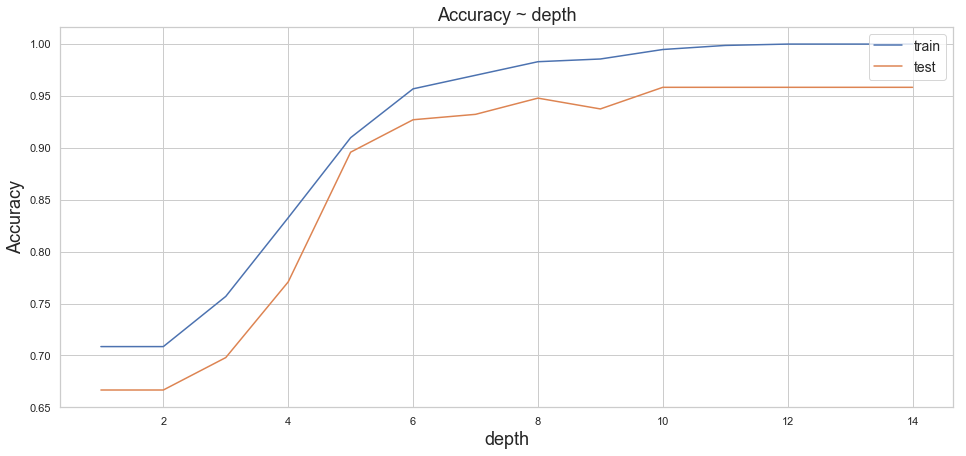

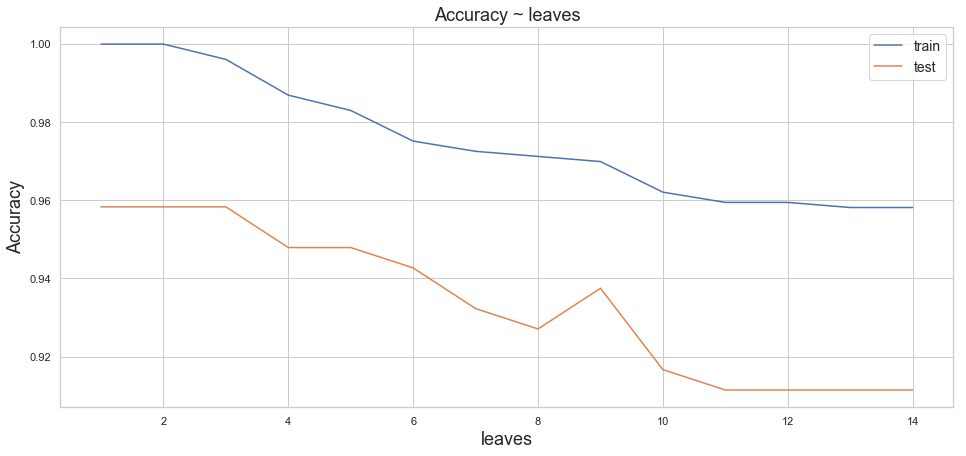

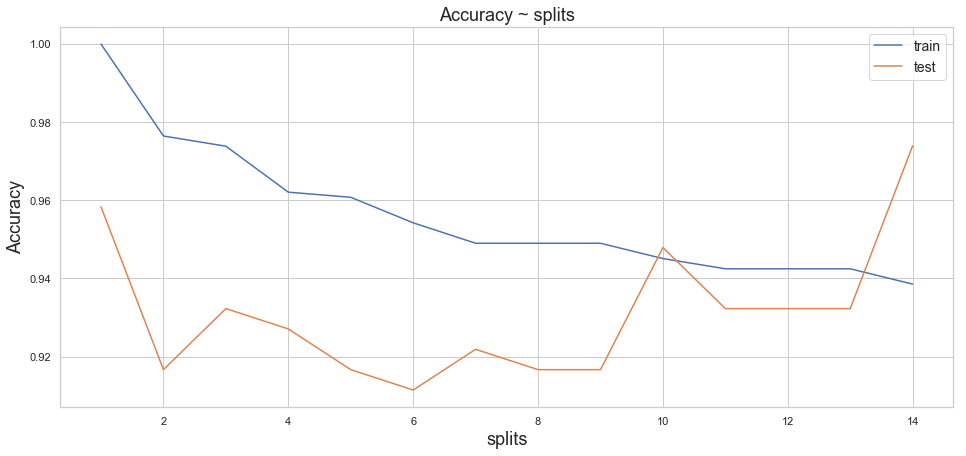

In [67]:
for param in train_scores:
    plot_param_acc(param)

**Ответ:** конечно, хотелось бы увидеть переобучение на первом графике и действие регуляризации на втором и третьем, но, похоже, данные слишком хорошие и тут и без регуляризации достигается 96%. Уменьшение сложности модели не приводит к улучшению результата.

**UPD:** ну вот, и тут графики поменялись. min_samples_split при определённых значениях повышает долю правильных ответов до почти 98%.